In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.6 MB/s eta 0:00:00


In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File paths
hh_path = '/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HH-ALPSRP084410210-H2.2_UA.tif'
hv_path = '/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HV-ALPSRP084410210-H2.2_UA.tif'
inc_path = '/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/INC-ALPSRP084410210-H2.2_UA.tif'

# Load the data
with rasterio.open(hh_path) as hh_src:
    hh = hh_src.read(1).astype('float32')
with rasterio.open(hv_path) as hv_src:
    hv = hv_src.read(1).astype('float32')
with rasterio.open(inc_path) as inc_src:
    inc = inc_src.read(1).astype('float32')


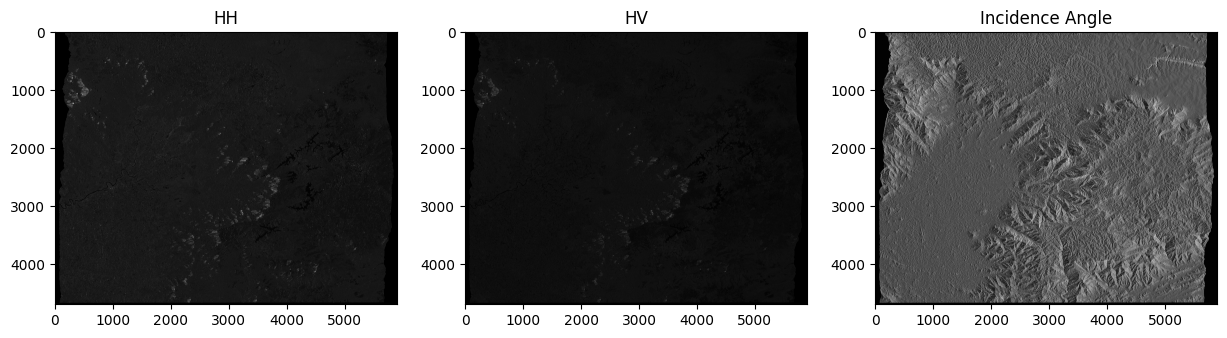

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(hh, cmap='gray')
plt.title('HH')

plt.subplot(1, 3, 2)
plt.imshow(hv, cmap='gray')
plt.title('HV')

plt.subplot(1, 3, 3)
plt.imshow(inc, cmap='gray')
plt.title('Incidence Angle')

plt.show()


In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Step 1: Load HH, HV, and INC files
hh_path = "/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HH-ALPSRP084410210-H2.2_UA.tif"
hv_path = "/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HV-ALPSRP084410210-H2.2_UA.tif"
inc_path = "/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/INC-ALPSRP084410210-H2.2_UA.tif"




In [ ]:
print("HH min/max:", np.nanmin(hh), np.nanmax(hh))
print("HV min/max:", np.nanmin(hv), np.nanmax(hv))

HH min/max: 0.0 65535.0
HV min/max: 0.0 53674.0


In [ ]:
# Convert DN to sigma⁰ (in dB)
sigma0_hh = 10 * np.log10((hh ** 2) * 0.0001)
sigma0_hv = 10 * np.log10((hv ** 2) * 0.0001)


<ipython-input-8-3dd0a4599ebc>:2: RuntimeWarning: divide by zero encountered in log10
  sigma0_hh = 10 * np.log10((hh ** 2) * 0.0001)
<ipython-input-8-3dd0a4599ebc>:3: RuntimeWarning: divide by zero encountered in log10
  sigma0_hv = 10 * np.log10((hv ** 2) * 0.0001)


In [ ]:
print("Sigma0 HH dB range:", np.nanmin(sigma0_hh), np.nanmax(sigma0_hh))
print("Sigma0 HV dB range:", np.nanmin(sigma0_hv), np.nanmax(sigma0_hv))


Sigma0 HH dB range: -inf 56.329464
Sigma0 HV dB range: -inf 54.59528


In [ ]:
# Avoid log10(0) by masking 0s
hh[hh <= 0] = np.nan
hv[hv <= 0] = np.nan

# Convert DN to sigma⁰ (in dB)
sigma0_hh = 10 * np.log10((hh ** 2) * 0.0001)
sigma0_hv = 10 * np.log10((hv ** 2) * 0.0001)


In [ ]:
print("Sigma0 HH dB range:", np.nanmin(sigma0_hh), np.nanmax(sigma0_hh))
print("Sigma0 HV dB range:", np.nanmin(sigma0_hv), np.nanmax(sigma0_hv))


Sigma0 HH dB range: -40.0 56.329464
Sigma0 HV dB range: -40.0 54.59528


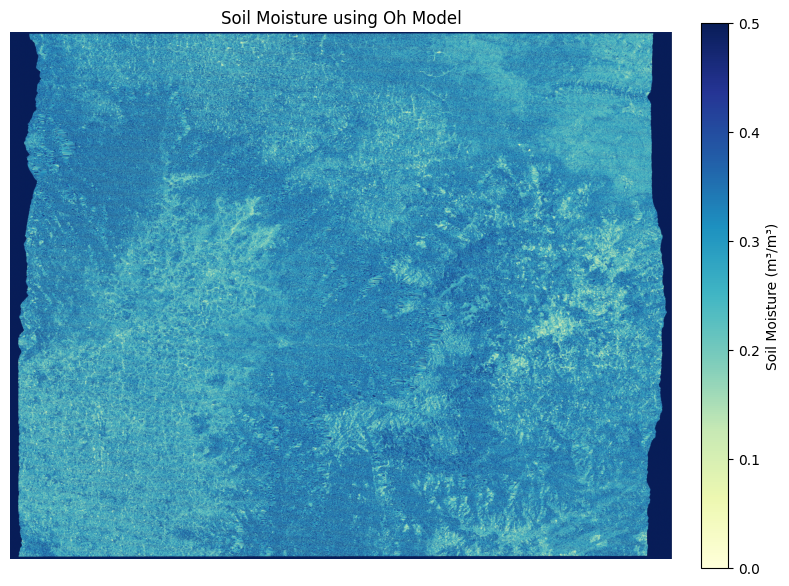

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Step 1: Load HH and HV Bands
with rasterio.open("/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HH-ALPSRP084410210-H2.2_UA.tif") as hh_src:
    hh = hh_src.read(1).astype(np.float32)
    profile = hh_src.profile

with rasterio.open("/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HV-ALPSRP084410210-H2.2_UA.tif") as hv_src:
    hv = hv_src.read(1).astype(np.float32)

# Step 2: Clean and Convert to Sigma0 in dB
hh[hh <= 0] = np.nan
hv[hv <= 0] = np.nan
sigma0_hh_db = 10 * np.log10((hh ** 2) * 0.0001)
sigma0_hv_db = 10 * np.log10((hv ** 2) * 0.0001)

# Step 3: Convert dB to Linear Scale
hh_linear = 10 ** (sigma0_hh_db / 10)
hv_linear = 10 ** (sigma0_hv_db / 10)

# Step 4: Calculate R = sigma0_HV / (sigma0_HH + ε)
epsilon = 1e-6
R = np.where(hh_linear > 0, hv_linear / (hh_linear + epsilon), np.nan)

# Step 5: Apply Oh Model for Soil Moisture Estimation
# Formula: mv = a * R^b + c (coefficients from Oh 2004)
a, b, c = 0.5, 0.6, 0.06  # Adjusted coefficients
soil_moisture = a * np.power(R, b) + c
soil_moisture = np.clip(soil_moisture, 0, 0.5)

# Step 6: Visualize the Soil Moisture Map with Adjusted Colorbar
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.YlGnBu
norm = mcolors.Normalize(vmin=0, vmax=0.5)
im = ax.imshow(soil_moisture, cmap=cmap, norm=norm)
ax.set_title("Soil Moisture using Oh Model")
ax.axis("off")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Soil Moisture (m³/m³)")
fig.tight_layout()
plt.savefig("soil_moisture_map.png")

# Step 7: Save the Result as GeoTIFF
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open("oh_model_soil_moisture.tif", "w", **profile) as dst:
    dst.write(soil_moisture.astype(np.float32), 1)

In [ ]:
print("R min:", np.nanmin(R))
print("R max:", np.nanmax(R))
print("R mean:", np.nanmean(R))


R min: 0.0005410166
R max: 9.839376
R mean: 0.3506597


In [ ]:
print("Soil Moisture min:", np.nanmin(soil_moisture))
print("Soil Moisture max:", np.nanmax(soil_moisture))
print("Soil Moisture mean:", np.nanmean(soil_moisture))


Soil Moisture min: 0.06548146
Soil Moisture max: 0.5
Soil Moisture mean: 0.30773365


In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# --- Constants ---
wavelength = 0.24  # L-band wavelength (meters)
h = 0.03  # surface roughness (meters)
a0, a1, a2, a3 = 0.053, 0.0292, -0.00055, 0.0000043  # Topp equation coefficients

# --- Load Data ---
with rasterio.open("/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HH-ALPSRP084410210-H2.2_UA.tif") as hh_src:
    hh = hh_src.read(1).astype(np.float32)

with rasterio.open("/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/INC-ALPSRP084410210-H2.2_UA.tif") as inc_src:
    inc = inc_src.read(1).astype(np.float32)

In [ ]:
# --- Calibration ---
calibration_factor = -83.0
hh[hh <= 0] = 1
hh_db = 20 * np.log10(hh) + calibration_factor

hh_db = np.clip(hh_db, -25, 0)

# --- Convert to sigma0 (linear) ---
sigma0_hh = 10 ** (hh_db / 10)

In [ ]:
 #--- Convert incidence to radians ---
inc_rad = np.deg2rad(inc)

In [ ]:
# --- Dielectric constant εᵣ ---
epsilon_r = ((sigma0_hh * wavelength**2) /
             (h**2 * np.sin(inc_rad)**2 * (1 + np.cos(inc_rad)**2)))**(1/3)
epsilon_r = np.clip(epsilon_r, 1, 25)

# --- Topp Model for θᵥ ---
theta_v = a0 + a1 * epsilon_r + a2 * epsilon_r**2 + a3 * epsilon_r**3
theta_v = np.clip(theta_v, 0, 0.5)



<ipython-input-11-c3a98056b20f>:2: RuntimeWarning: divide by zero encountered in divide
  epsilon_r = ((sigma0_hh * wavelength**2) /


Text(0, 0.5, 'Frequency')

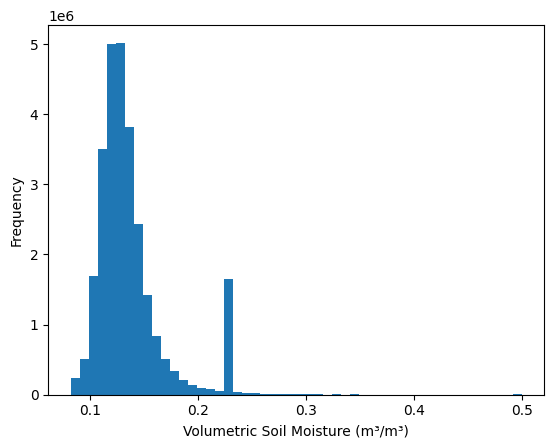

In [ ]:
plt.hist(theta_v[~np.isnan(theta_v)].flatten(), bins=50)
plt.xlabel('Volumetric Soil Moisture (m³/m³)')
plt.ylabel('Frequency')


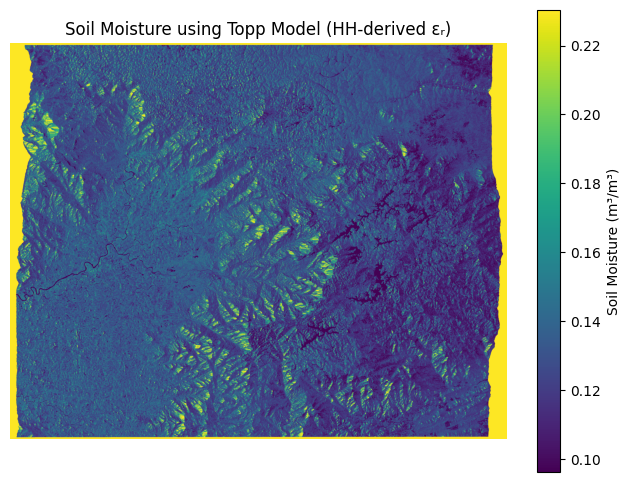

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Soil Moisture using Topp Model (HH-derived εᵣ)")
vmin = np.percentile(theta_v, 2)
vmax = np.percentile(theta_v, 98)
plt.imshow(theta_v, cmap='viridis', vmin=vmin, vmax=vmax)


plt.colorbar(label='Soil Moisture (m³/m³)')
plt.axis('off')
plt.show()

<ipython-input-14-c23c9fbff48f>:30: RuntimeWarning: divide by zero encountered in divide
  epsilon_r = ((sigma0_hh * wavelength**2) /


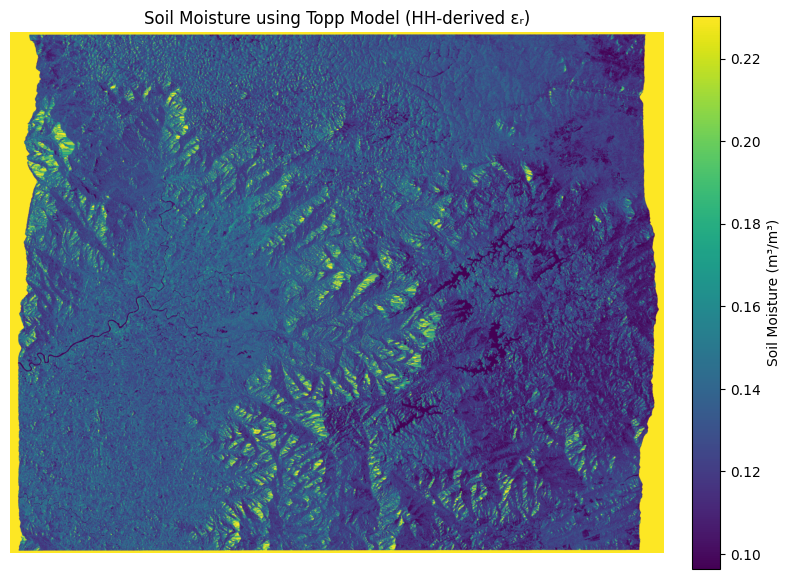

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Step 1: Define Constants
wavelength = 0.24  # L-band wavelength (meters)
h = 0.03          # Surface roughness (meters)
a0, a1, a2, a3 = 0.053, 0.0292, -0.00055, 0.0000043  # Topp equation coefficients

# Step 2: Load Data
with rasterio.open("/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HH-ALPSRP084410210-H2.2_UA.tif") as hh_src:
    hh = hh_src.read(1).astype(np.float32)

with rasterio.open("/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/INC-ALPSRP084410210-H2.2_UA.tif") as inc_src:
    inc = inc_src.read(1).astype(np.float32)

# Step 3: Calibration
calibration_factor = -83.0
hh[hh <= 0] = 1
hh_db = 20 * np.log10(hh) + calibration_factor
hh_db = np.clip(hh_db, -25, 0)

# Step 4: Convert to Sigma0 (Linear)
sigma0_hh = 10 ** (hh_db / 10)

# Step 5: Convert Incidence Angle to Radians
inc_rad = np.deg2rad(inc)

# Step 6: Calculate Dielectric Constant (εᵣ)
epsilon_r = ((sigma0_hh * wavelength**2) /
             (h**2 * np.sin(inc_rad)**2 * (1 + np.cos(inc_rad)**2)))**(1/3)
epsilon_r = np.clip(epsilon_r, 1, 25)

# Step 7: Apply Topp Model for Soil Moisture (θᵥ)
theta_v = a0 + a1 * epsilon_r + a2 * epsilon_r**2 + a3 * epsilon_r**3
theta_v = np.clip(theta_v, 0, 0.5)

# Step 8: Visualize the Soil Moisture Map with Adjusted Colorbar
fig, ax = plt.subplots(figsize=(8, 6))
vmin = np.percentile(theta_v, 2)
vmax = np.percentile(theta_v, 98)
im = ax.imshow(theta_v, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title("Soil Moisture using Dubois Model (HH-derived εᵣ)")
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Soil Moisture (m³/m³)')
fig.tight_layout()
plt.savefig("soil_moisture_topp_map.png")

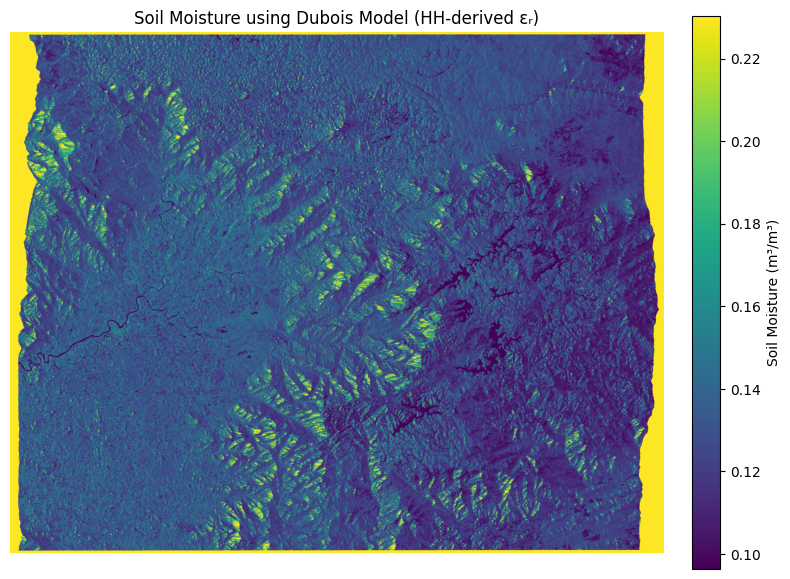

In [ ]:
# Step 8: Visualize the Soil Moisture Map with Adjusted Colorbar
fig, ax = plt.subplots(figsize=(8, 6))
vmin = np.percentile(theta_v, 2)
vmax = np.percentile(theta_v, 98)
im = ax.imshow(theta_v, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title("Soil Moisture using Dubois Model (HH-derived εᵣ)")
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Soil Moisture (m³/m³)')
fig.tight_layout()
plt.savefig("soil_moisture_topp_map.png")

In [ ]:
Label Generation (y_labels)

✅ GeoTIFF saved to: /content/Wysoil_moisture_dubois.tif


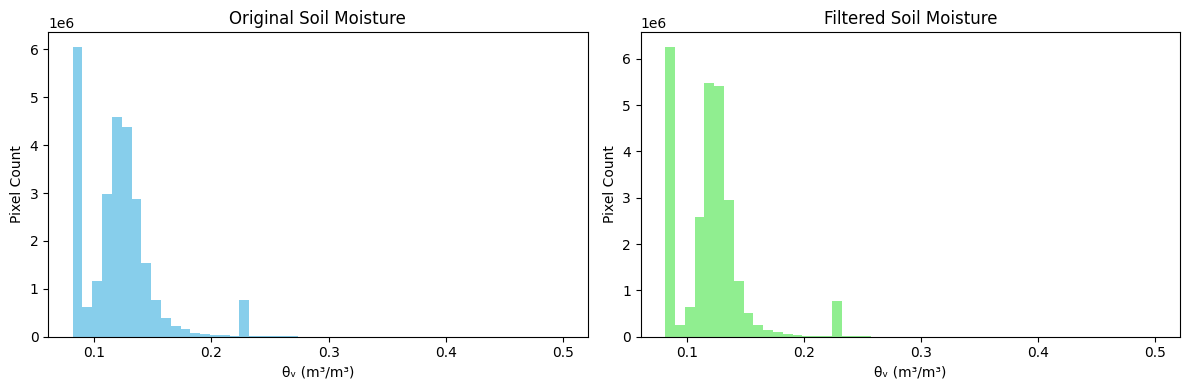

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(theta_v.flatten(), bins=50, color='skyblue')
ax[0].set_title('Original Soil Moisture')
ax[1].hist(theta_filtered.flatten(), bins=50, color='lightgreen')
ax[1].set_title('Filtered Soil Moisture')
for a in ax:
    a.set_xlabel('θᵥ (m³/m³)')
    a.set_ylabel('Pixel Count')
plt.tight_layout()
plt.show()


In [ ]:
with rasterio.open("soil_moisture_output.tif", "w",
                   driver="GTiff",
                   height=theta_v.shape[0],
                   width=theta_v.shape[1],
                   count=1,
                   dtype=theta_v.dtype,
                   crs=hh_src.crs,
                   transform=hh_src.transform) as dst:
    dst.write(theta_v, 1)


In [ ]:
import rasterio

# Path to any one of your cropped TIFF files
file_path = "/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/HH-ALPSRP084410210-H2.2_UA.tif"

with rasterio.open(file_path) as src:
    width = src.width
    height = src.height
    crs = src.crs
    transform = src.transform

print(f"Image Width (columns): {width}")
print(f"Image Height (rows): {height}")
print(f"CRS: {crs}")
print(f"Transform (Pixel Size & Origin): {transform}")


Image Width (columns): 5900
Image Height (rows): 4700
CRS: PROJCS["WGS 84 / UTM zone 43N",GEOGCS["ITRF97 (geocentric)",DATUM["International_Terrestrial_Reference_Frame_1997",SPHEROID["GRS 1980",6378137,298.257221538149,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6655"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4338"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]
Transform (Pixel Size & Origin): | 12.25, 2.50, 615004.49|
| 2.50,-12.25, 1277499.57|
| 0.00, 0.00, 1.00|


In [ ]:
import rasterio

# Path to any one of your cropped TIFF files
file_path = "/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP084410210-H2.2_UA/CHV-ALPSRP084410210-H2.2_UA.tif"

with rasterio.open(file_path) as src:
    width = src.width
    height = src.height
    crs = src.crs
    transform = src.transform

print(f"Image Width (columns): {width}")
print(f"Image Height (rows): {height}")
print(f"CRS: {crs}")
print(f"Transform (Pixel Size & Origin): {transform}")

Image Width (columns): 176
Image Height (rows): 339
CRS: EPSG:32643
Transform (Pixel Size & Origin): | 12.25, 0.00, 624886.84|
| 0.00,-12.25, 1272907.60|
| 0.00, 0.00, 1.00|


In [ ]:
import rasterio

# Path to your cropped image
file_path = "/content/drive/MyDrive/new PALSAR WAYANAD/ALPSRP191770210-H2.2_UA/cHH-ALPSRP191770210-H2.2_UA.tif"

with rasterio.open(file_path) as src:
    width = src.width        # number of columns
    height = src.height      # number of rows
    transform = src.transform

    # Pixel size (resolution in meters)
    pixel_width = transform[0]   # e.g., 12.5 meters
    pixel_height = -transform[4]  # usually negative due to top-left origin

    # Area = width * height * pixel area (converted to km²)
    total_area_m2 = width * height * pixel_width * pixel_height
    total_area_km2 = total_area_m2 / 1e6

print(f"Image Size: {width} x {height} pixels")
print(f"Pixel Size: {pixel_width}m x {pixel_height}m")
print(f"Total Area: {total_area_km2:.2f} km²")


Image Size: 177 x 339 pixels
Pixel Size: 12.245007265913198m x 12.244476353750024m
Total Area: 9.00 km²
